**Table of Contents**
<div id="toc"></div>

# Log

## 11/04/2019:
    bla bla bla
## 12/04/2019
    zzzzzzzz
## 13/04/2019

# Imports

In [1]:
import os.path
from math import isnan

import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import container
# from matplotlib.lines import Line2D

from person import Person
from visit import Visit

# from model import create_vae


from keras import backend as K
from keras.layers import LSTM, Input, RepeatVector
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

Using TensorFlow backend.


# Constants

In [2]:
# Number of visits to be used in the model
NR_VISITS = 4

# currently read vars from each enroll visit
fields_enroll = ['subjid', 'seq', 'visit', 'age', 'hdcat', 'motscore', 'miscore', 'tfcscore', 'fascore', 'fiscore',
                 'sdmt1', 'sdmt2', 'sit1', 'sit2', 'sit3', 'depscore', 'irascore', 'psyscore', 'aptscore', 'exfscore']

# currently read vars from each profile
fields_profile = ['subjid', 'sex', 'region', 'race', 'hxsid', 'caghigh', 'caglow', 'momhd', 'momagesx', 'dadhd',
                  'dadagesx', 'fhx']

# current vars used in the model
_vars = ['caglow', 'caghigh', 'tfcscore', 'motscore', 'age']
# 'fascore', 'depscore', 'sdmt1'] 

# Profile plot generation (def)

In [3]:
def generate_profile_plots():
    print("not done")
    
    

    # Some plots #

    # Sex distribution by group:
    sex_count = np.zeros(shape=(2, 3))

    for i in persons:
        if i.state == 3:
            j = 2
        elif i.state == 2:
            j = 1
        else:
            j = 0
        if i.sex == 0:
            sex_count[0, j] += 1
        elif i.sex == 1:
            sex_count[1, j] += 1
        else:
            print("Sex NA")

    # fig, ax = plt.subplots()
    # ind = np.arange(3)
    # width = 0.35
    # rects1 = ax.bar(ind, sex_count[0])
    # rects2 = ax.bar(ind+ width, sex_count[1], color='black')
    # ax.set_ylabel('#')
    # ax.set_title('Gender by group')
    # ax.set_xticks(ind + width / 2)
    # xTickMarks = ['Control', 'Pre-Manifest', 'Post-Manifest']
    # xtickNames = ax.set_xticklabels(xTickMarks)
    # plt.setp(xtickNames, rotation=45, fontsize=10)
    # ax.legend( (rects1[0], rects2[0]), ('Women', 'Men') )


    # ax.set_xticklabels(('Control', 'Pre-Manifest', 'Post-Manifest'))
    # ax.legend((rects1[0], rects2[0]), ('Women', 'Men'))
    # ax.set_ylabel('#')
    # ax.set_title('Sex distribuition over classification group')

# _vars plot generation (def)

generate_vars_plots(): Generates some plots for the variables used in the model. The plots are the mean and std and a scatter plot showing where the data is distributed along each visit. Blue for Controls, Yellow for Pre-Manifest and Red for Post-Manifest.

In [4]:
def generate_vars_plots():

    def autolabel():
        # Attach a text label next to each value to display its value (only used for mean atm)
        
        for i in ind:
            axs1[0].text(i + 0.24*width, mean[i, _index] + axs1[0].get_yaxis().get_tick_padding()*0.2, '%f' % mean[i, _index], fontsize=15)
            axs1[0].text(i + 1.04*width, mean_pre[i, _index] + axs1[0].get_yaxis().get_tick_padding()*0.2, '%f' % mean_pre[i, _index], fontsize=15)
            axs1[0].text(i + 1.84*width, mean_post[i, _index] + axs1[0].get_yaxis().get_tick_padding()*0.2, '%f' % mean_post[i, _index], fontsize=15)

    for var in _vars:
        _index = _vars.index(var)
        ind = np.arange(NR_VISITS)
        width = 0.30
        fig1, axs1 = plt.subplots(2, 1, figsize=(20, 10), sharex='col')
        fig1.suptitle(var, fontsize=16)
        
        rects_1 = axs1[0].errorbar(ind + 0.2*width, mean[:, _index], std[:, _index], color='b', linestyle='None', marker='o', capsize=2, label="Control")
        rects_2 = axs1[0].errorbar(ind + width, mean_pre[:, _index], std_pre[:, _index], color='y', linestyle='None', marker='o', capsize=2, label="Pre")
        rects_3 = axs1[0].errorbar(ind + (1.8*width), mean_post[:, _index], std_post[:, _index], color='r',
                                   linestyle='None', marker='o', capsize=2, label="Post")
        
        axs1[0].set_ylabel('Value')
        axs1[0].set_title("Mean and std")
        axs1[0].set_xticks(ind + width)
        start, end = axs1[0].get_ylim()
        axs1[0].set_yticks(np.arange(round(start)-1, round(end)+1, round((end-start)/10)))
        axs1[0].grid(linestyle='--', alpha=0.7)
        autolabel()

        # Remove std drawing from the legend
        handles, labels = axs1[0].get_legend_handles_labels()
        new_handles = []

        for h in handles:
            # only need to edit the errorbar legend entries
            if isinstance(h, container.ErrorbarContainer):
                new_handles.append(h[0])
            else:
                new_handles.append(h)

        fig1.legend(new_handles, labels, loc='center right')
        fig1.subplots_adjust(hspace=0.15)

        # Scatter Plot #
        
        axs1[1].set_ylabel('Value')
        axs1[1].set_xlabel('Visit Number')
        axs1[1].set_title("Scatter plot")
        axs1[1].set_xticks(ind + width)
        axs1[1].set_xticklabels(np.arange(1,NR_VISITS+1))

        # create x values for all the Y values with random to distribute them along the visit's width
        for z in ind:
            _x1 = np.ones(control_data.shape[0])*(z + 0.2*width) + (np.random.uniform(-1.0, 1.0, control_data.shape[0]) * width/3)
            axs1[1].scatter(_x1, control_data[:, z, _index], facecolors='none', edgecolor='b', s=5)
            
            _x2 = np.ones(pre_data.shape[0])*(z + width) + (np.random.uniform(-1.0, 1.0, pre_data.shape[0]) * width/3)
            axs1[1].scatter(_x2, pre_data[:, z, _index], facecolors='none', edgecolor='y', s=5)
            
            _x3 = np.ones(post_data.shape[0])*(z + 1.8*width) + (np.random.uniform(-1.0, 1.0, post_data.shape[0]) * width/3)
            axs1[1].scatter(_x3, post_data[:, z, _index], facecolors='none', edgecolor='r', s=5)
            
        start, end = axs1[1].get_ylim()
        axs1[1].set_yticks(np.arange(round(start)-1, round(end)+1, round((end-start)/10)))
        axs1[1].grid(linestyle='--', alpha=0.7)

    plt.show()

# Prediction plot generation (def)

In [5]:
    # Plots after prediction
    
    def generate_pred_plots():
        
        n_plots = NR_VISITS
        #print(n_plots)
        n_cols = n_plots // 2
        #print(n_cols)
        n_rows = n_plots // n_cols
        #print(n_rows)
        n_rows += n_plots % n_cols
        #print(n_rows)
        position = np.arange(1, n_plots +1)
        
        for var in _vars:
            _index = _vars.index(var)
            fig = plt.figure(1, figsize=(20,10))
            fig.suptitle(var, fontsize=16)
            for i in range(NR_VISITS):
                ax = fig.add_subplot(n_rows, n_cols, position[i])
                ax.plot(control_data[:, i, _index], 'ro', mfc='none', label='data')
                ax.plot(preds[:, i, _index], 'bo', mfc='none', label='predict')
                ax.legend(loc='upper right')
                ax.set_title("Visit %d" % (i+1))
            
            plt.show()
                

# Get Data

Get the data from the DB

In [6]:
    pre = 0
    post = 0
    control = 0

    nr_vis_ok = {}
    nr_vis = {}

    four_visits = []
    four_pre = []
    four_post = []
    four_control = []

    if os.path.exists('Data/enroll.csv'):
        df = pandas.read_csv('Data/enroll.csv', dtype={"age": str}, usecols=fields_enroll)
        #print(df)
    else:
        print("no file - enroll.csv")

    if os.path.exists('Data/profile.csv'):
        df_p = pandas.read_csv('Data/profile.csv', delimiter='\t', usecols=fields_profile)
        #print(df_p)
    else:
        print("no file - profile.csv")

    print("Total entries: ", len(df))

    subjids = {}
    persons = []
    count = 0
    df2 = df.values
    df2_p = df_p.values

    for index, i in enumerate(df['subjid']):

        seq = df2[index, 1]
        visit = df2[index, 2]
        age = df2[index, 3] if df2[index, 3] != '<18' else 17
        hdcat = df2[index, 4]
        motscore = df2[index, 5]
        miscore = df2[index, 6]
        tfcscore = df2[index, 7]
        fascore = df2[index, 8]
        fiscore = df2[index, 9]
        sdmt1 = df2[index, 10]
        sdmt2 = df2[index, 11]
        sit1 = df2[index, 12]
        sit2 = df2[index, 13]
        sit3 = df2[index, 14]
        depscore = df2[index, 15]
        irascore = df2[index, 16]
        psyscore = df2[index, 17]
        aptscore = df2[index, 18]
        exfscore = df2[index, 19]
        #print(sdmt1, sdmt2)

        # New ENROLL visit data (selected)

        new_visit = Visit(seq, age, visit, hdcat, motscore, miscore, tfcscore, fascore, fiscore, sdmt1, sdmt2, sit1,
                          sit2, sit3, depscore, irascore, psyscore, aptscore, exfscore)

        if i not in subjids:
            # New person

            persons.append(Person(i, hdcat))
            persons[count].add_visit(new_visit)

            # Count Baseline and FUP only
            if new_visit.visit in ['Baseline', 'Follow Up']:
                persons[count].visits_ok += 1

            # Index in persons array
            count += 1

            # Total visit count
            subjids[i] = 1

        else:
            # Increase counters and add new visit
            subjids[i] += 1
            persons[count-1].add_visit(new_visit)
            if new_visit.visit in ['Baseline', 'Follow Up']:
                persons[count-1].visits_ok += 1
    
    # counters  for each of the 3 groups
    for i in persons:
        if i.state == 2:
            pre += 1
        elif i.state == 3:
            post += 1
        else:
            control += 1

        if i.visits_ok not in nr_vis_ok:
            nr_vis_ok[i.visits_ok] = 1
        else:
            nr_vis_ok[i.visits_ok] += 1
        if i.visits not in nr_vis:
            nr_vis[i.visits] = 1
        else:
            nr_vis[i.visits] += 1

        if i.visits_ok == NR_VISITS:
            # Persons with 4 visits total and 4 visits baseline + FUP
            four_visits.append(i)
            # Separated by control, pre-manifest, and post-manifest
            if i.state == 2:
                four_pre.append(i)
            elif i.state == 3:
                four_post.append(i)
            else:
                four_control.append(i)

    print("%d Pre, %d post, %d controls." % (pre, post, control))
    print("nr_vis_ok ->", nr_vis_ok)
    print("nr_vis -> ", nr_vis)
    print("length 4 visits-> ", len(four_visits))
    print("%d Pre, %d post, %d controls." % (len(four_pre), len(four_post), len(four_control)))

    for index, i in enumerate(df_p['subjid']):
        region = df2_p[index, 1]
        sex = df2_p[index, 2]
        race = df2_p[index, 3]
        hxsid = df2_p[index, 4]
        caghigh = df2_p[index, 5] if df2_p[index, 5] != ">70" else 71
        caglow = df2_p[index, 6] if df2_p[index, 6] != ">28" else 29
        momhd = df2_p[index, 7]
        momagesx = df2_p[index, 8]
        dadhd = df2_p[index, 9]
        dadagesx = df2_p[index, 10]
        fhx = df2_p[index, 11]

        persons[index].add_info(region, sex, race, hxsid, caghigh, caglow, momhd, momagesx, dadhd, dadagesx, fhx)

    # Data #

    control_data = np.zeros(shape=(len(four_control), NR_VISITS, len(_vars)))
    pre_data = np.zeros(shape=(len(four_pre), NR_VISITS, len(_vars)))
    post_data = np.zeros(shape=(len(four_post), NR_VISITS, len(_vars)))

    control_labels = np.chararray(shape=(len(four_control), 1))
    pre_labels = np.chararray(shape=(len(four_pre), 1))
    post_labels = np.chararray(shape=(len(four_post), 1))

    for index, i in enumerate(four_control):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                control_data[index, c, 0] = i.caglow
                control_data[index, c, 1] = i.caghigh
                control_data[index, c, 2] = j.tfcscore
                control_data[index, c, 3] = j.motscore if j.motscore == j.motscore else j.miscore
                control_data[index, c, 4] = j.age 
                #control_data[index, c, 5] = j.fascore if j.fascore == j.fascore else j.fiscore
                #control_data[index, c, 6] = j.depscore
                #control_data[index, c, 7] = j.sdmt1
                
                c += 1
                if c == NR_VISITS:
                    break
        control_labels[index] = i.subjid

    for index, i in enumerate(four_pre):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                pre_data[index, c, 0] = i.caglow
                pre_data[index, c, 1] = i.caghigh 
                pre_data[index, c, 2] = j.tfcscore
                pre_data[index, c, 3] = j.motscore if j.motscore == j.motscore else j.miscore
                pre_data[index, c, 4] = j.age
                #pre_data[index, c, 5] = j.fascore if j.fascore == j.fascore else j.fiscore
                #pre_data[index, c, 6] = j.depscore
                #pre_data[index, c, 7] = j.sdmt1
                c += 1
                if c == NR_VISITS:
                    break
        pre_labels[index] = i.subjid

    for index, i in enumerate(four_post):
        c = 0
        for index2, j in enumerate(i.visit_list):
            if j.visit != "Phone Contact":
                post_data[index, c, 0] = i.caglow 
                post_data[index, c, 1] = i.caghigh
                post_data[index, c, 2] = j.tfcscore
                post_data[index, c, 3] = j.motscore if j.motscore == j.motscore else j.miscore
                post_data[index, c, 4] = j.age
               # post_data[index, c, 5] = j.fascore if j.fascore == j.fascore else j.fiscore
                #post_data[index, c, 6] = j.depscore
                #post_data[index, c, 7] = j.sdmt1
                c += 1
                if c == NR_VISITS:
                    break
        post_labels[index] = i.subjid

    control_data = control_data.astype('float32')
    pre_data = pre_data.astype('float32')
    post_data = post_data.astype('float32')

    # Entries to be removed from the used data - ones with nan values on the required fields and outliers -> age =17,
    # caghigh = 71, caglow = 29 tbd

    to_del = []
    for index, x1 in np.ndenumerate(control_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996]:
            print(index, x1, end='\n')
            if index not in to_del:
                to_del.append(index)

    control_data = np.delete(control_data, to_del, 0)
    control_labels = np.delete(control_labels, to_del, 0)

    to_del = []
    for index, x1 in np.ndenumerate(pre_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996]:
            print(index, x1, end='\n')
            if index not in to_del:
                to_del.append(index)

    pre_data = np.delete(pre_data, to_del, 0)
    pre_labels = np.delete(pre_labels, to_del, 0)

    to_del = []
    for index, x1 in np.ndenumerate(post_data):
        if isnan(x1) or x1 in [9999,9998,9997,9996]:
            print(index, x1, end='\n')
            if index not in to_del:
                to_del.append(index)

    post_data = np.delete(post_data, to_del, 0)
    post_labels = np.delete(post_labels, to_del, 0)

    # used data plots #

    std = control_data.std(axis=0)
    mean = control_data.mean(axis=0)

    std_pre = pre_data.std(axis=0)
    mean_pre = pre_data.mean(axis=0)

    std_post = post_data.std(axis=0)
    mean_post = post_data.mean(axis=0)
    
    #print(mean[:,7])
    #print(mean_pre[:, 7])
    #print(mean_post[:, 7])
    
    #print(std[:,7])
    #print(std_pre[:, 7])
    #print(std_post[:, 7])
    
    
    #print(np.amax(post_data[:,:,7]))
    #print(np.amax(pre_data[:,:,7]))
    #print(np.amax(control_data[:,:,7]))
    

Total entries:  41304
2842 Pre, 7324 post, 5135 controls.
nr_vis_ok -> {5: 898, 3: 3317, 4: 2177, 2: 3766, 1: 4876, 6: 261, 7: 6}
nr_vis ->  {5: 1208, 4: 2639, 2: 3676, 3: 3594, 1: 3722, 6: 408, 8: 11, 9: 5, 7: 37, 12: 1}
length 4 visits->  2177
395 Pre, 1343 post, 439 controls.
(345, 2, 2) nan
(394, 2, 2) nan
(394, 2, 3) nan
(6, 0, 2) nan
(6, 1, 3) nan
(31, 2, 2) nan
(31, 2, 3) nan
(131, 0, 2) nan
(146, 1, 3) nan
(181, 2, 2) nan
(181, 2, 3) nan
(185, 3, 2) nan
(200, 2, 3) nan
(275, 1, 2) nan
(392, 0, 2) nan
(26, 1, 2) nan
(26, 1, 3) nan
(76, 1, 2) nan
(76, 1, 3) nan
(182, 3, 3) nan
(215, 1, 2) nan
(215, 1, 3) nan
(387, 1, 2) nan
(387, 1, 3) nan
(437, 1, 2) nan
(437, 1, 3) nan
(448, 0, 2) nan
(462, 2, 3) nan
(474, 0, 2) nan
(517, 1, 3) nan
(669, 1, 2) nan
(788, 1, 2) nan
(797, 0, 2) nan
(845, 2, 2) nan
(881, 0, 3) nan
(1021, 2, 3) nan
(1224, 1, 2) nan
(1224, 1, 3) nan


# Data Info

In [7]:
#df.loc[(df['state'] !=2 )&]

Generate some info on the data acquired

In [8]:
print(mean)

[[17.087357  22.666666  12.429885   5.386207  49.128735 ]
 [17.087357  22.666666  12.416092   5.597701  50.229885 ]
 [17.087357  22.666666  12.317242   5.7287354 51.268967 ]
 [17.087357  22.666666  12.285057   6.013793  52.34253  ]]


# _vars plots

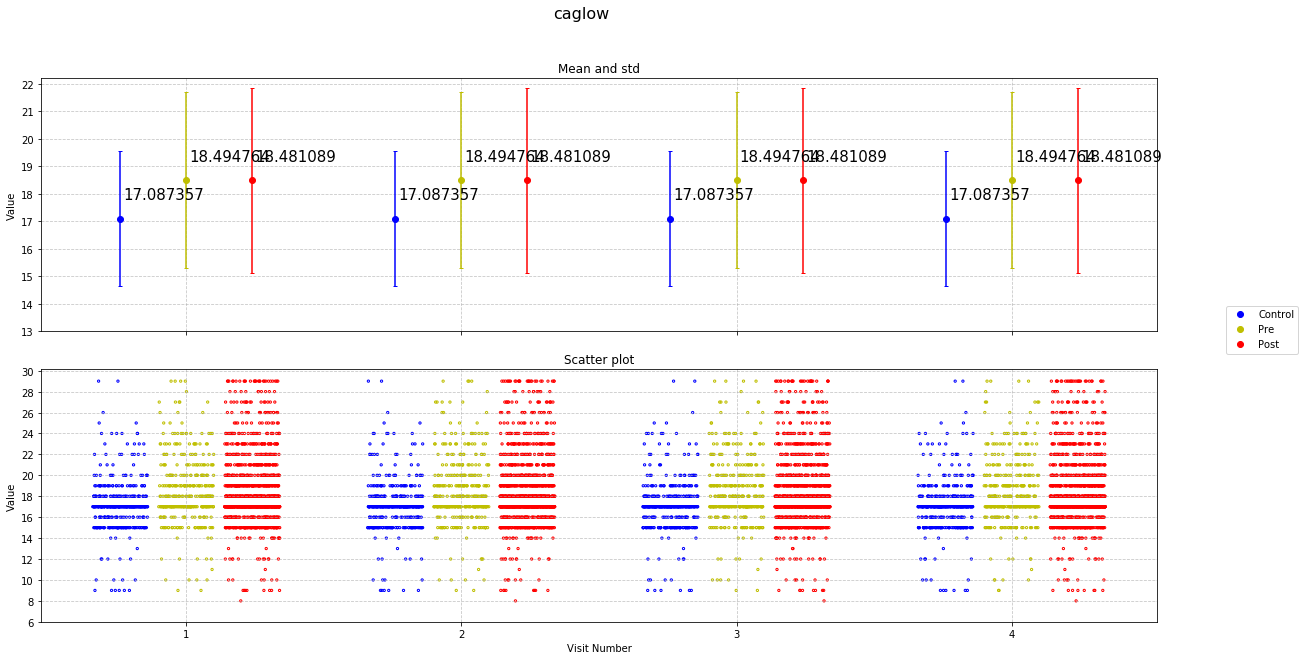

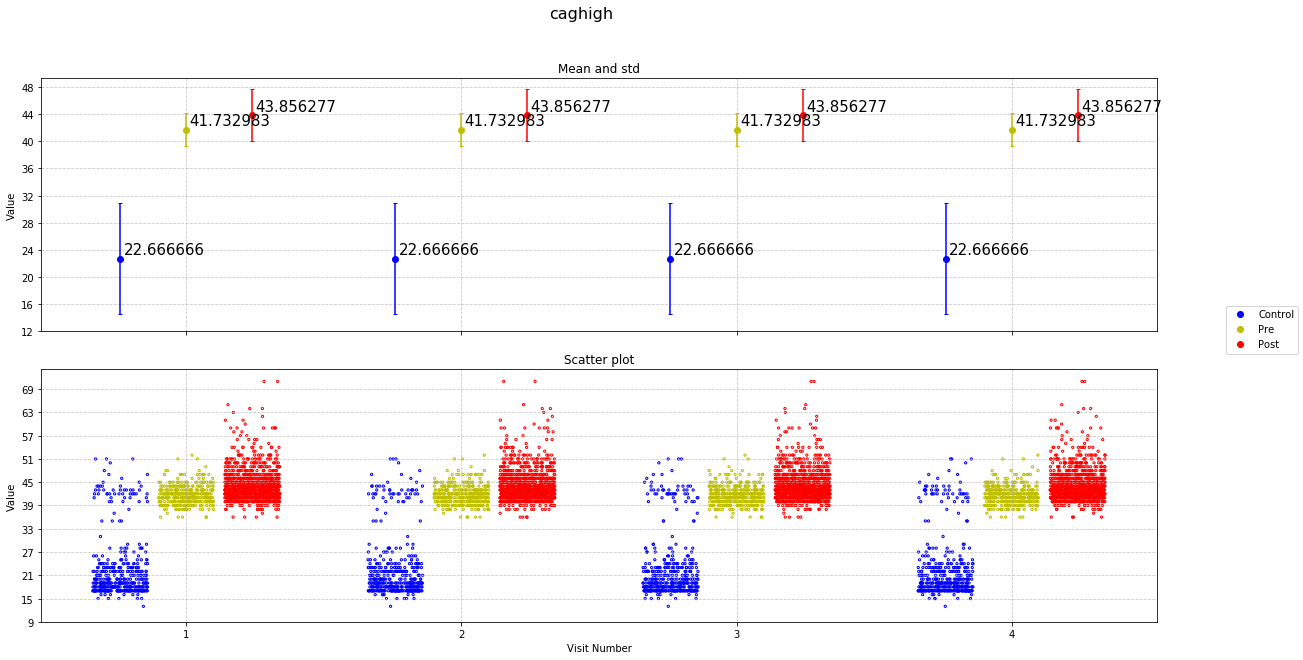

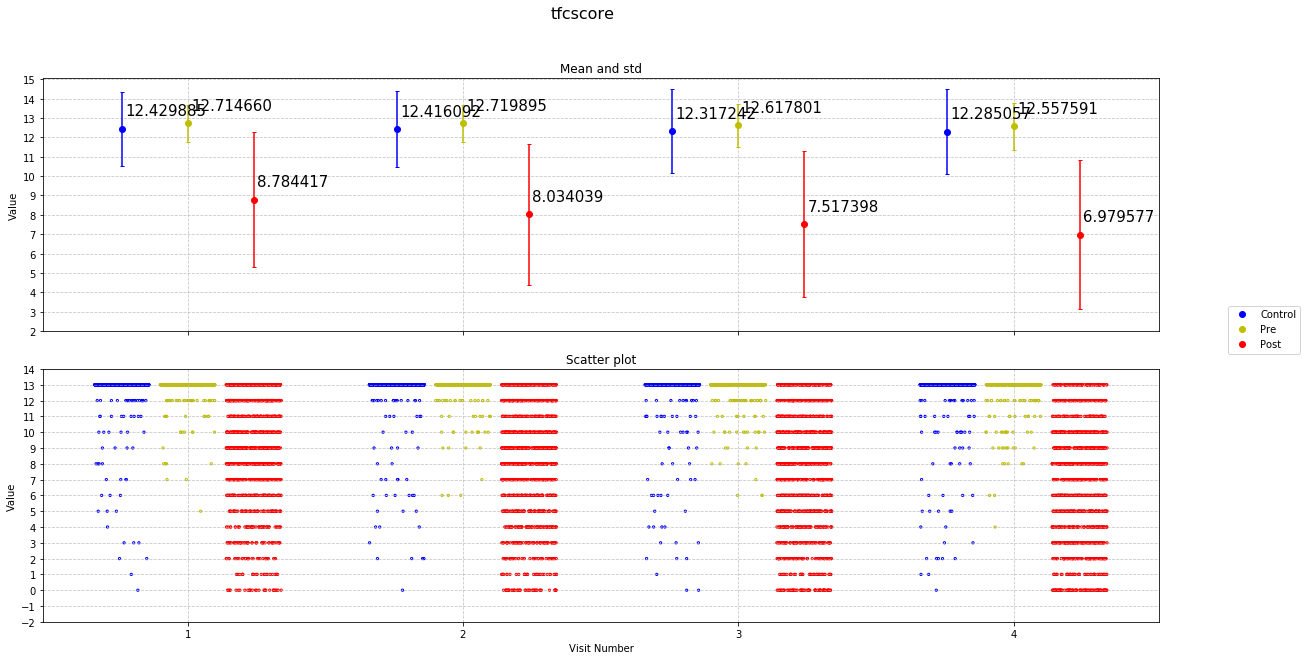

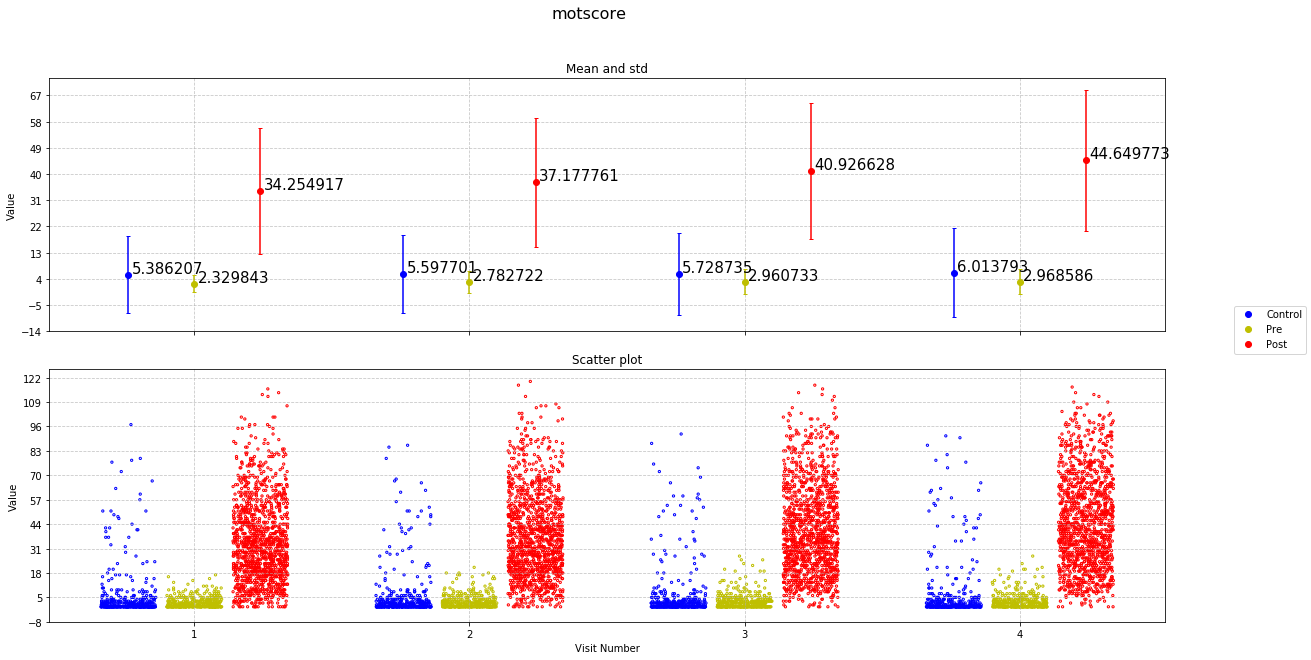

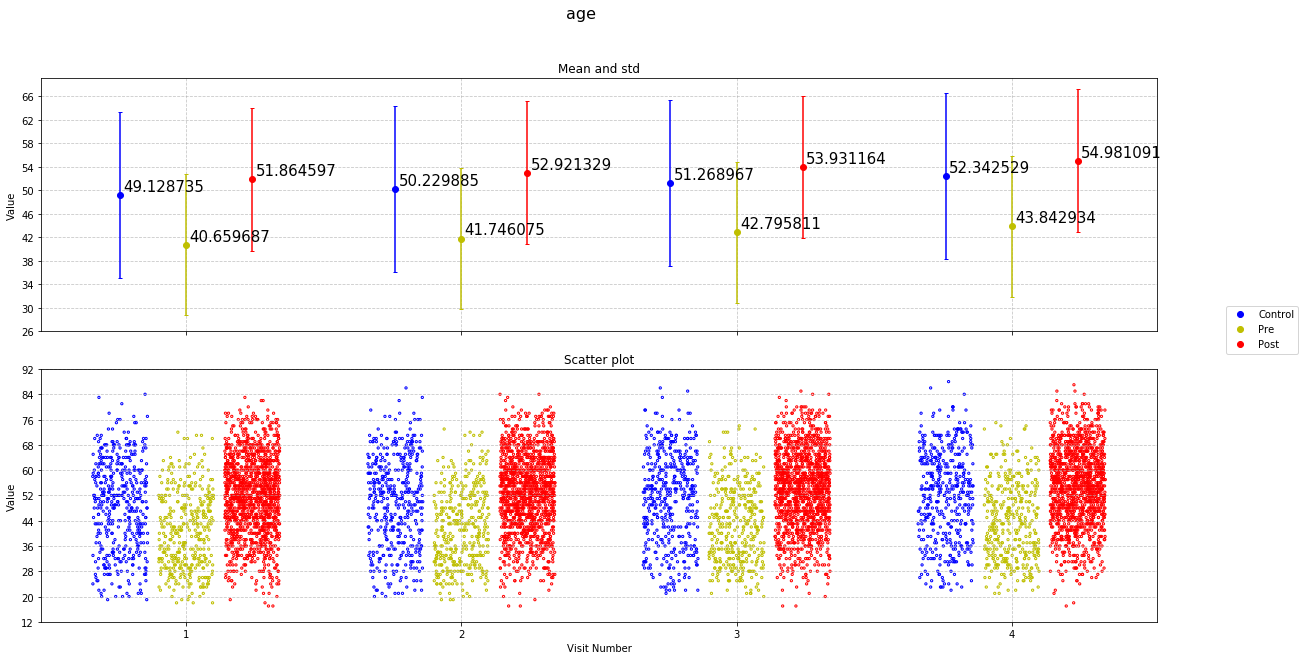

In [9]:
    generate_vars_plots() # caglow and caghigh obviously won't change with time

# Network

## Model definition 

In [10]:

# model #

def create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta):
    x = Input(shape=(timesteps, input_dim))     # Inputs
    h = LSTM(intermediate_dim)(x)       # LSTM output

    # Latent space
    z_mean = Dense(latent_dim, activation='linear')(h)
    z_log_sigma = Dense(latent_dim, activation='softplus')(h)

    # Sampling

    def sampling(args):
        z_mean, z_log_sigma = args
        #epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
        #epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=epsilon_std)
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    # decoded LSTM layer

    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    x_decoded_mean = decoder_mean(h_decoded)

    # end-to-end autoencoder

    vae = Model(x, x_decoded_mean)

    # encoder: inputs to latent space

    encoder = Model(x, z_mean)

    # generator: from latent space to reconstructed inputs

    decoder_input = Input(shape=(latent_dim, ))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)

    generator = Model(decoder_input, _x_decoded_mean)

    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss * beta
        return loss

    vae.compile(optimizer='adam', loss=vae_loss)

    return vae, encoder, generator

## Running the model

In [11]:
    # Plots after pred #
    def plot_loss(t):
        fig = plt.figure(1, figsize=(20,10))
        plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='Training Loss')
        plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title(t)
        plt.show()
        

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


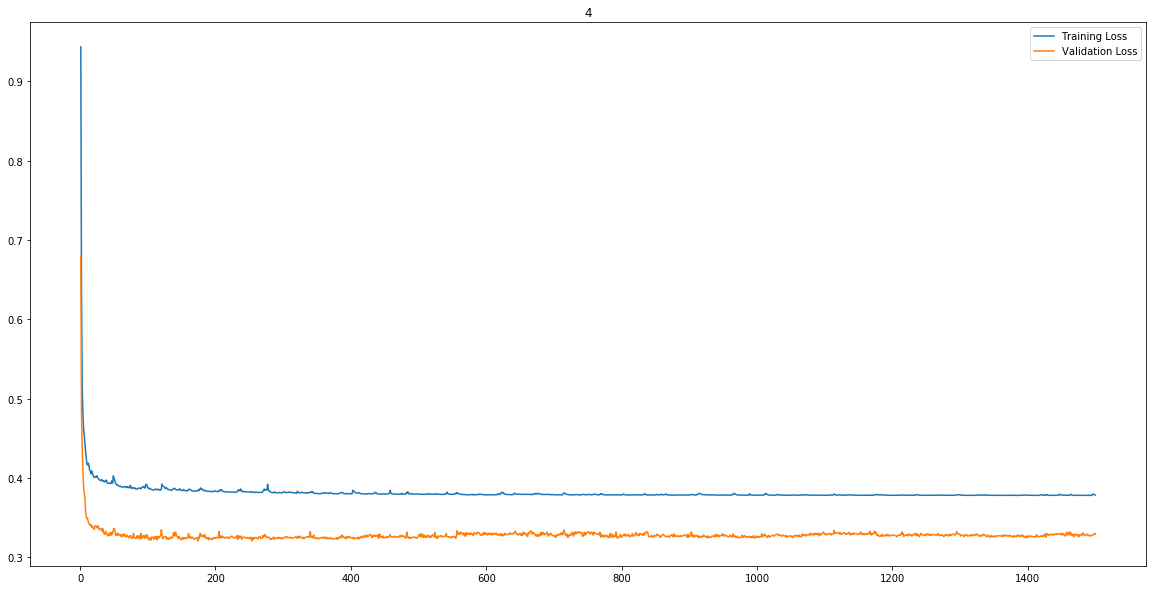

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


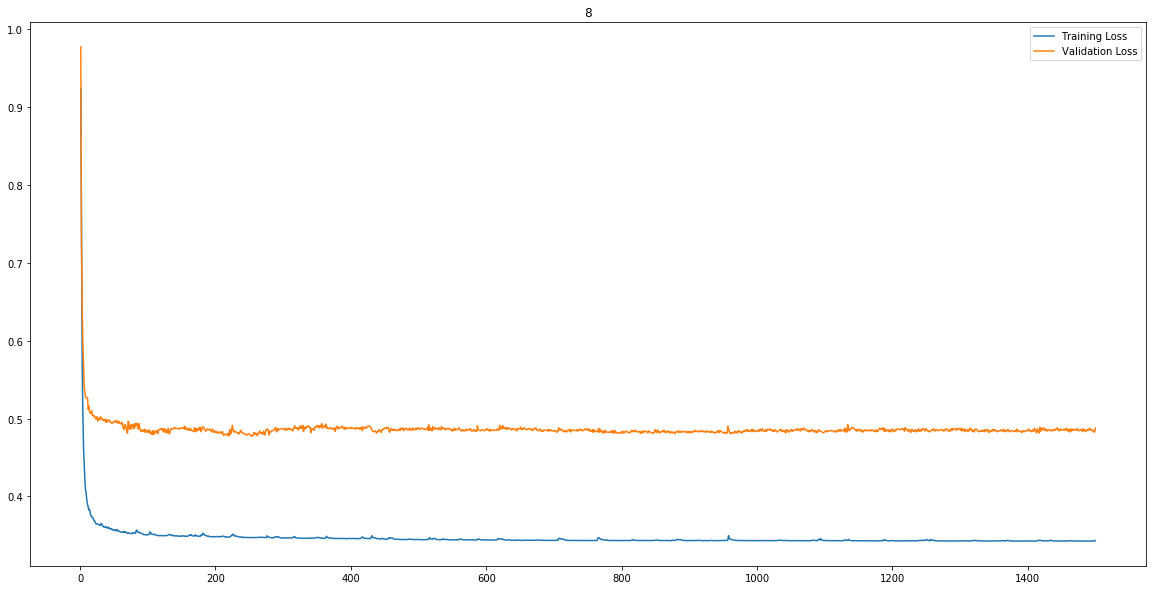

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


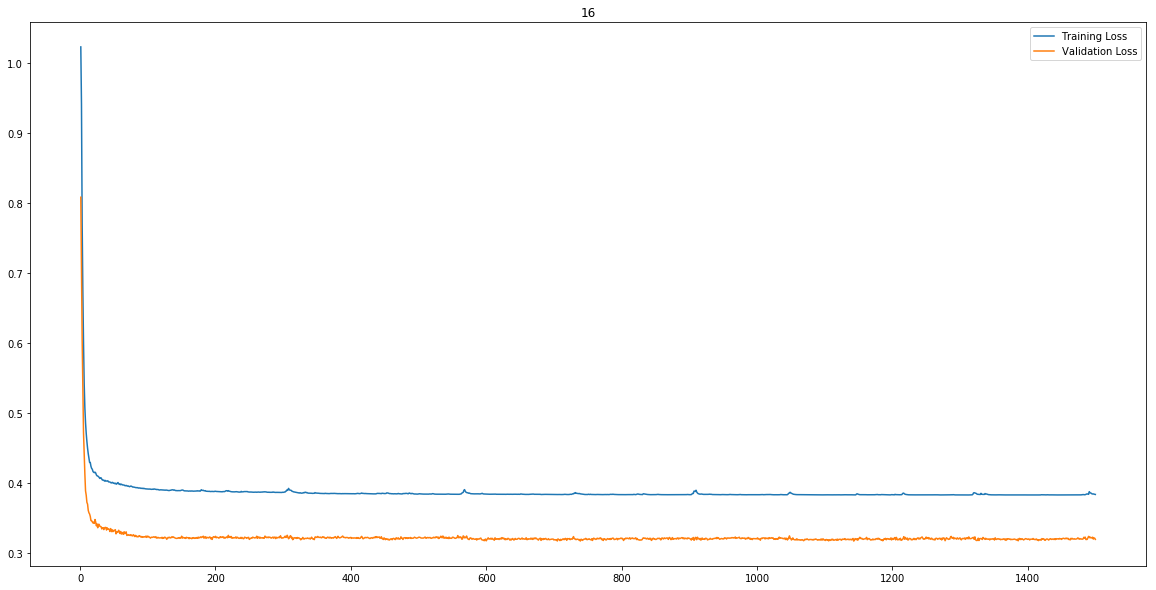

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


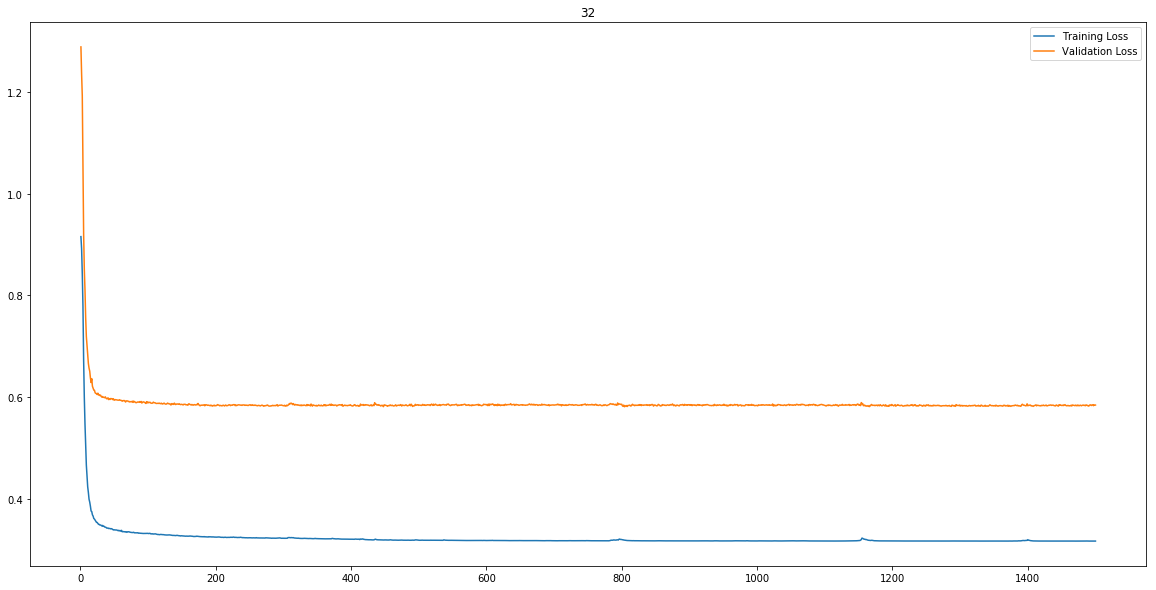

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


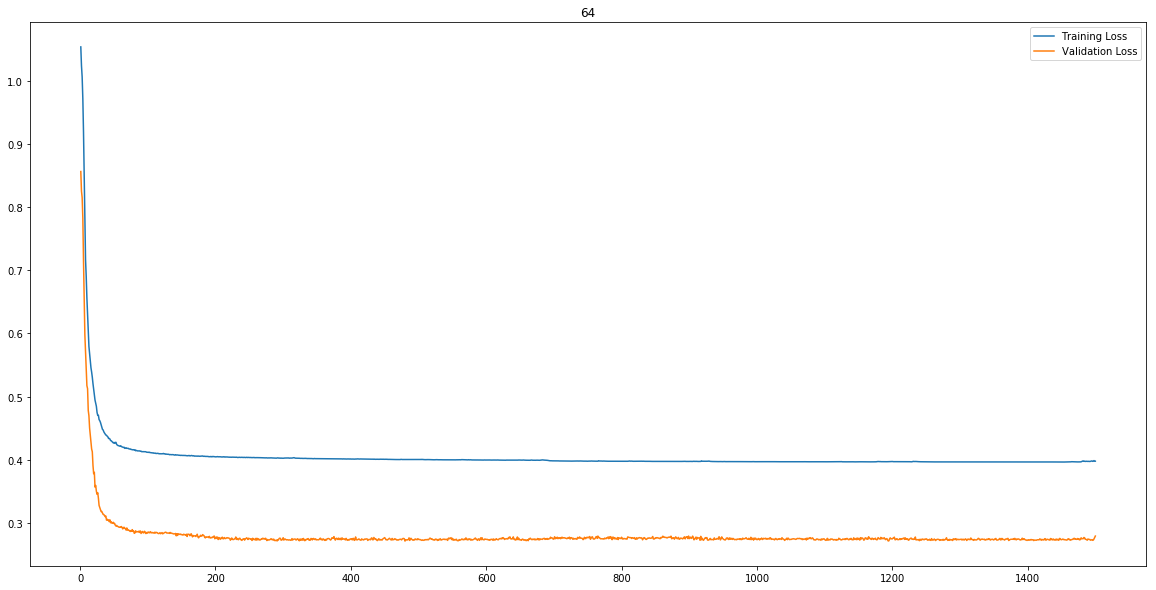

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


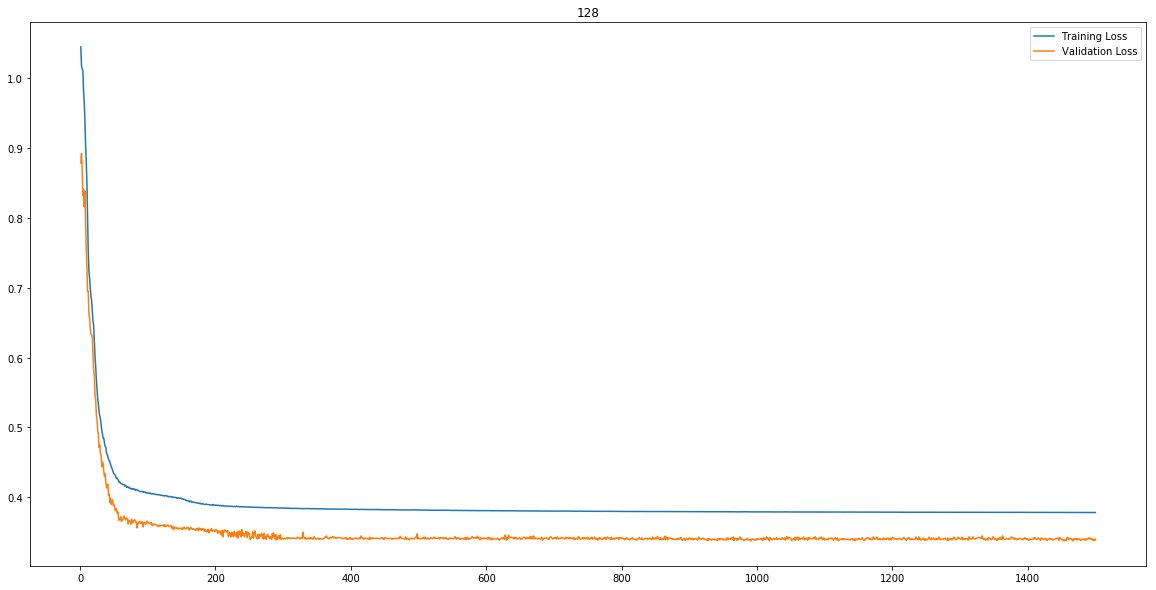

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


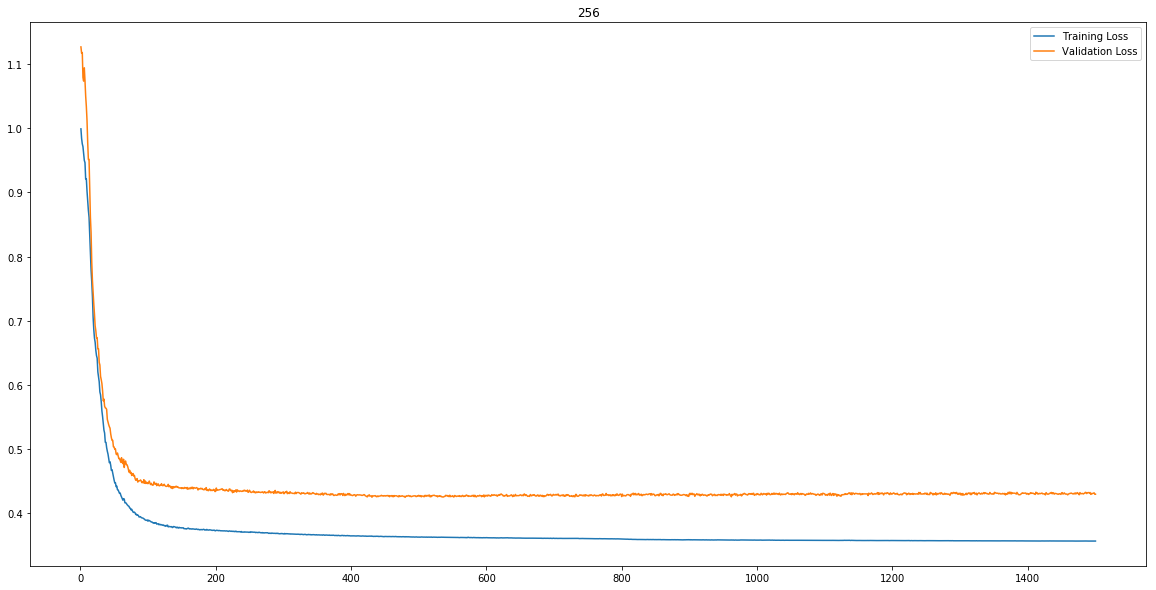

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


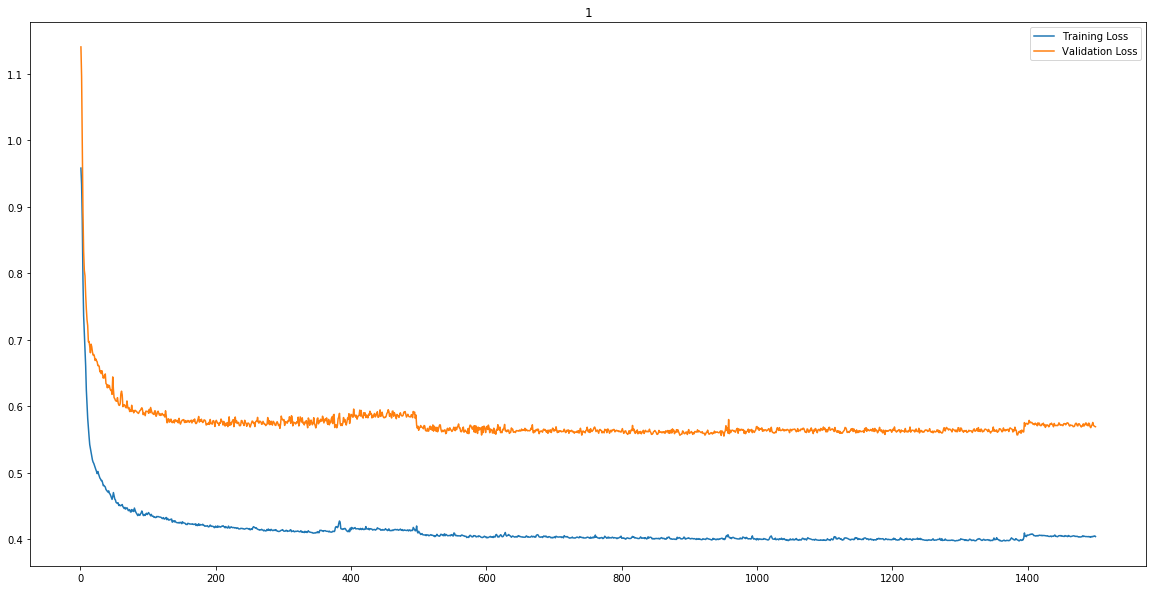

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


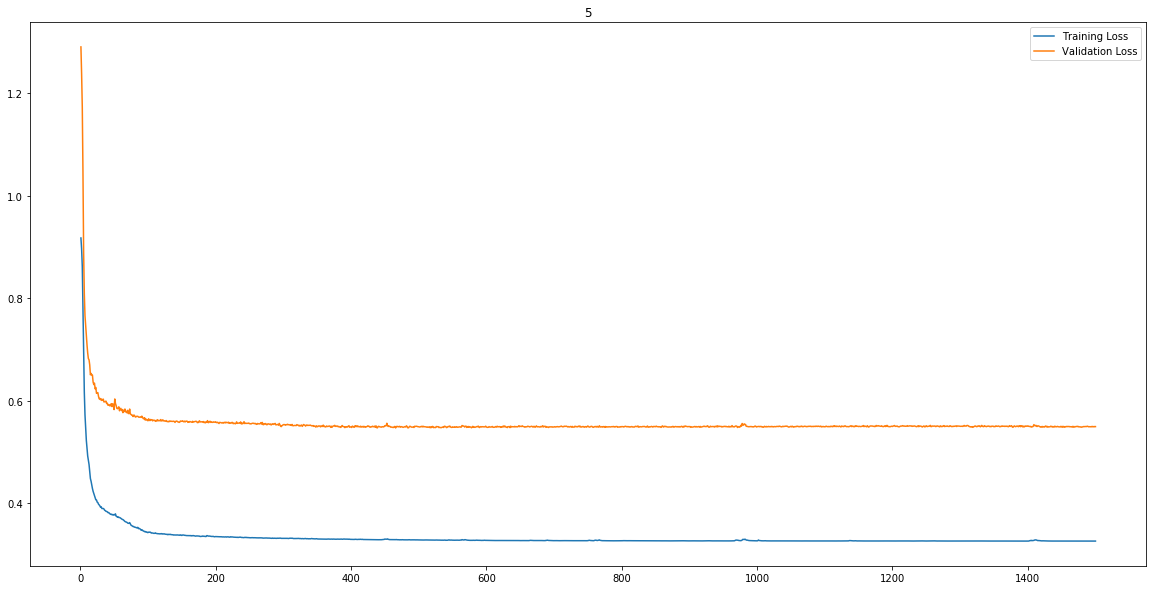

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


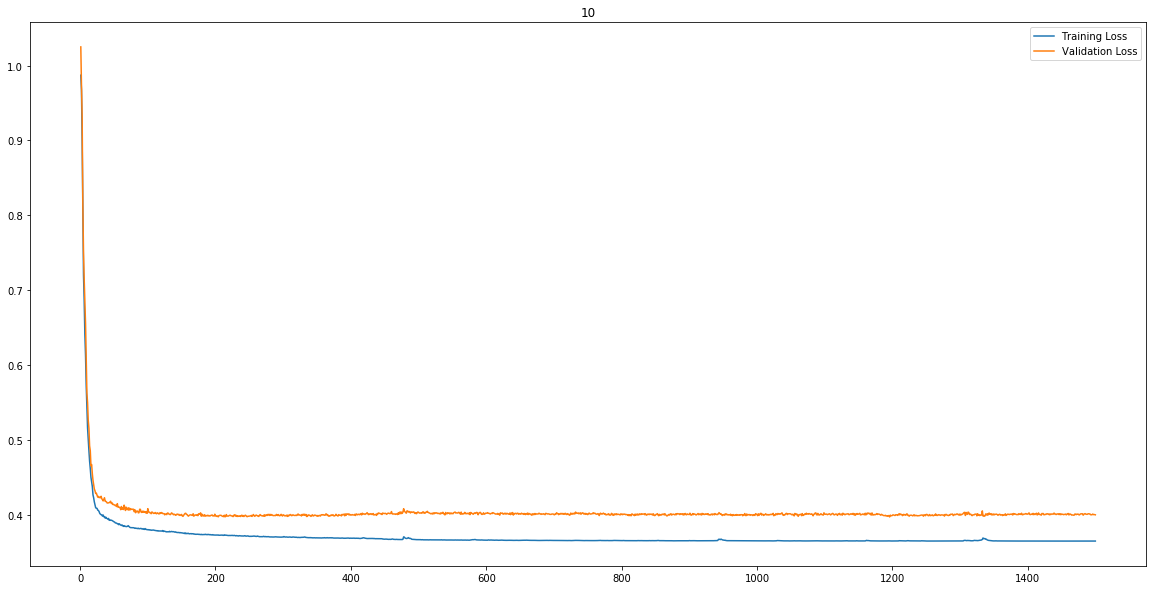

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


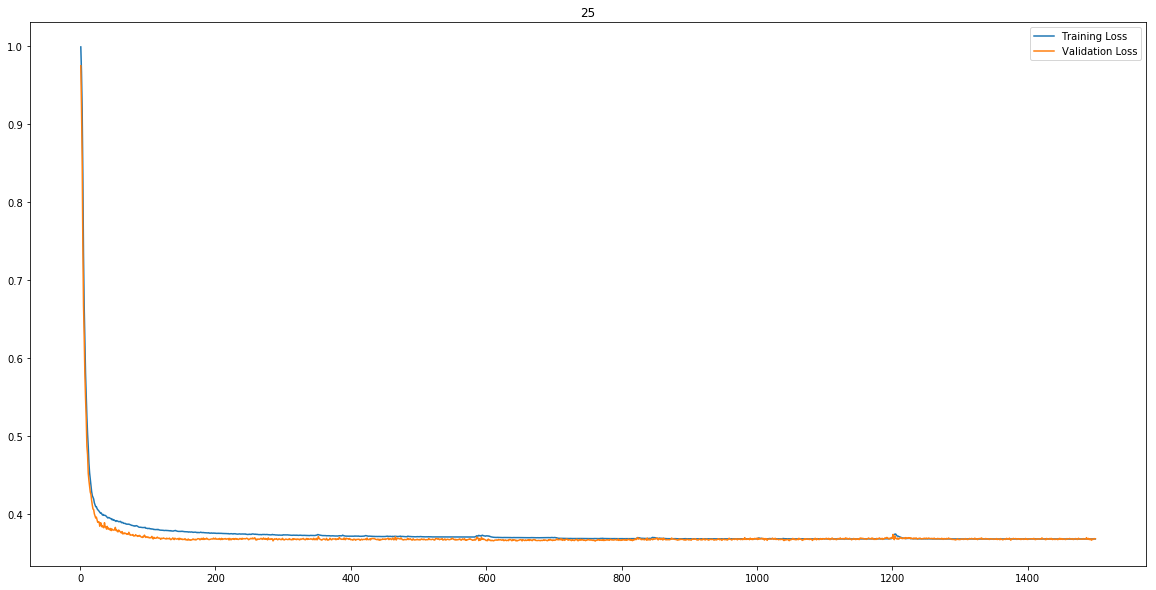

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


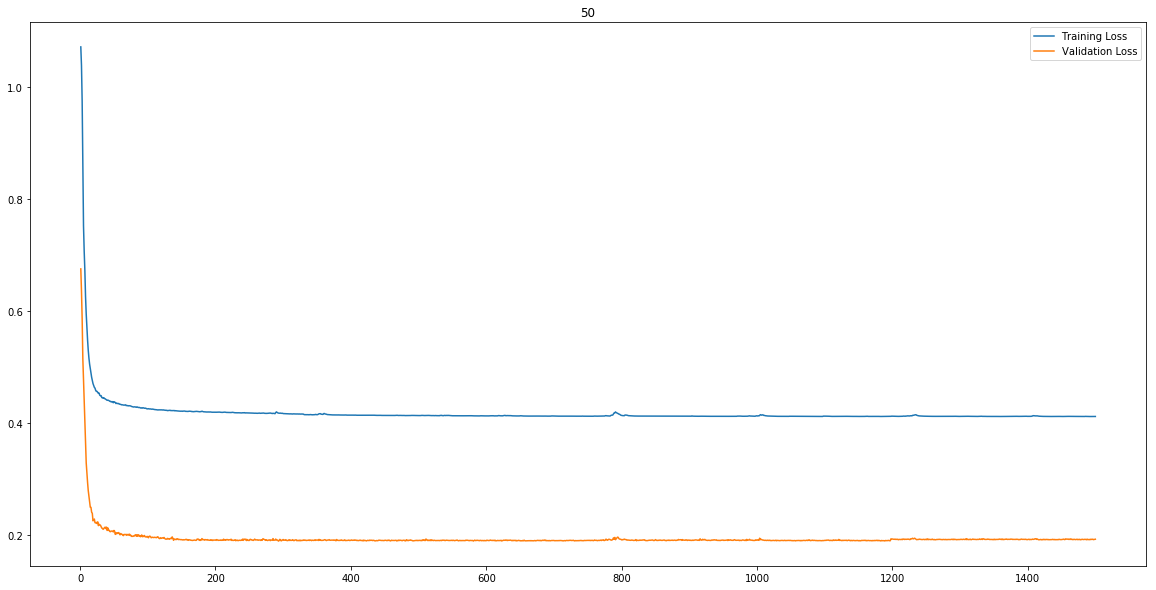

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


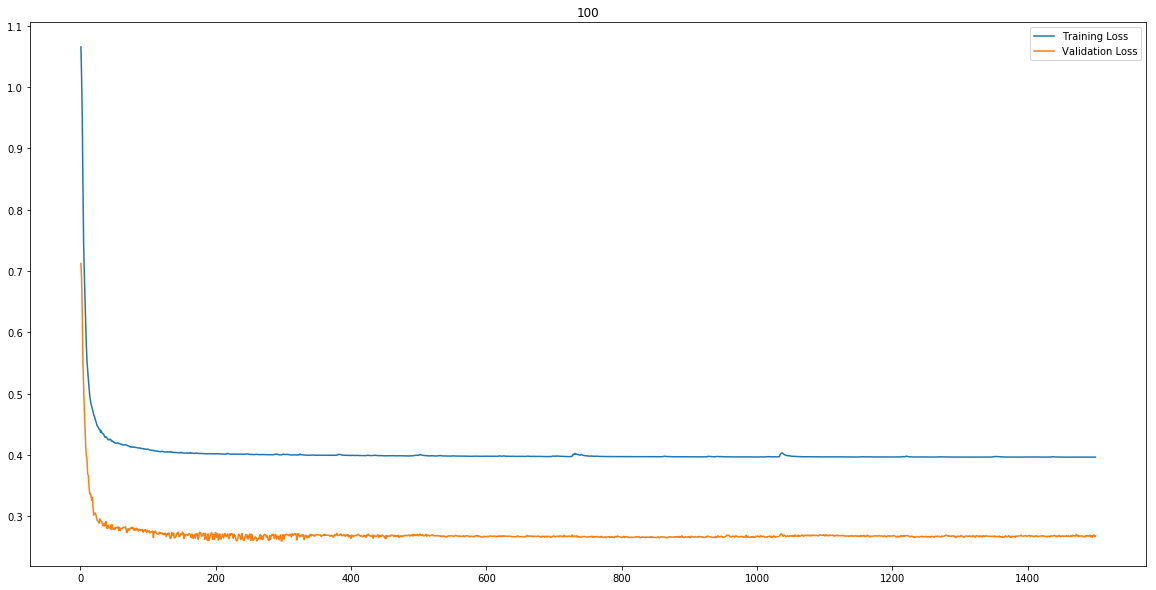

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


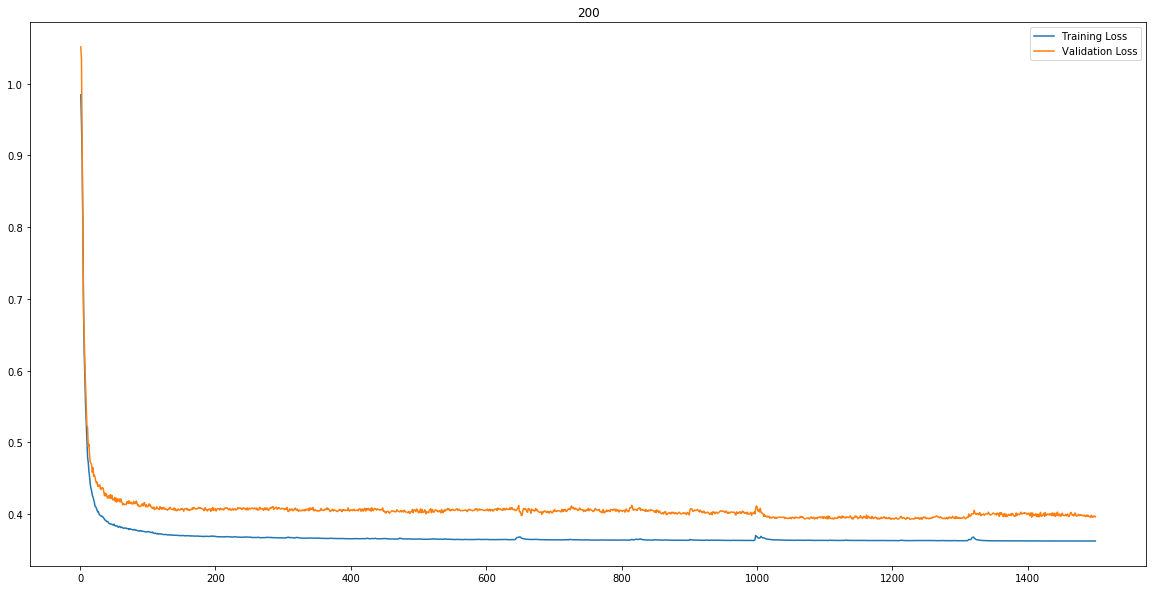

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


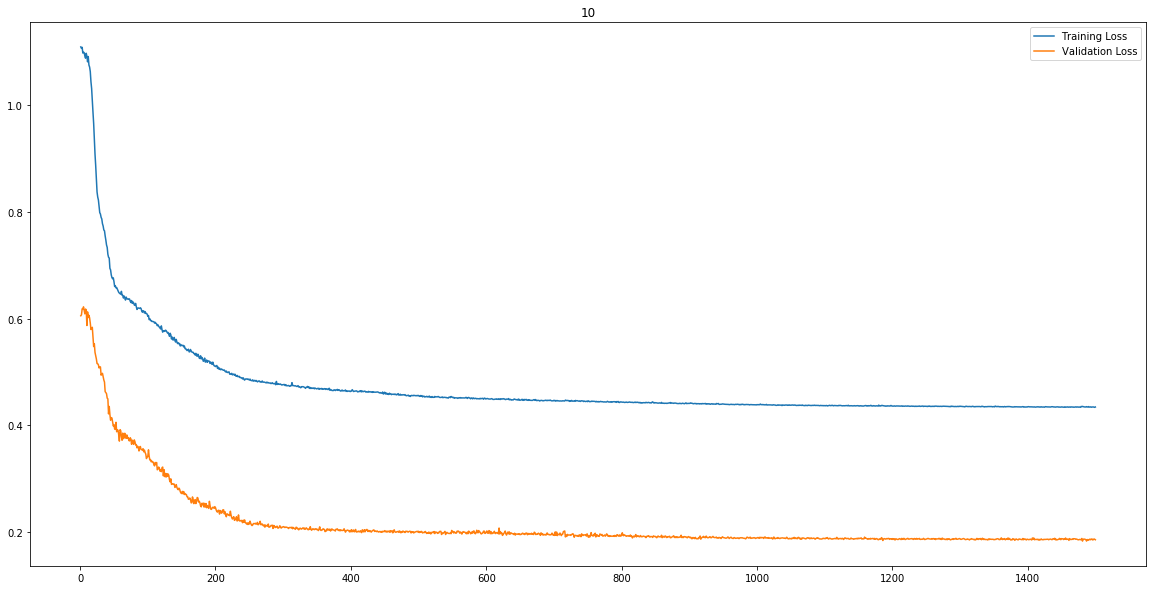

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


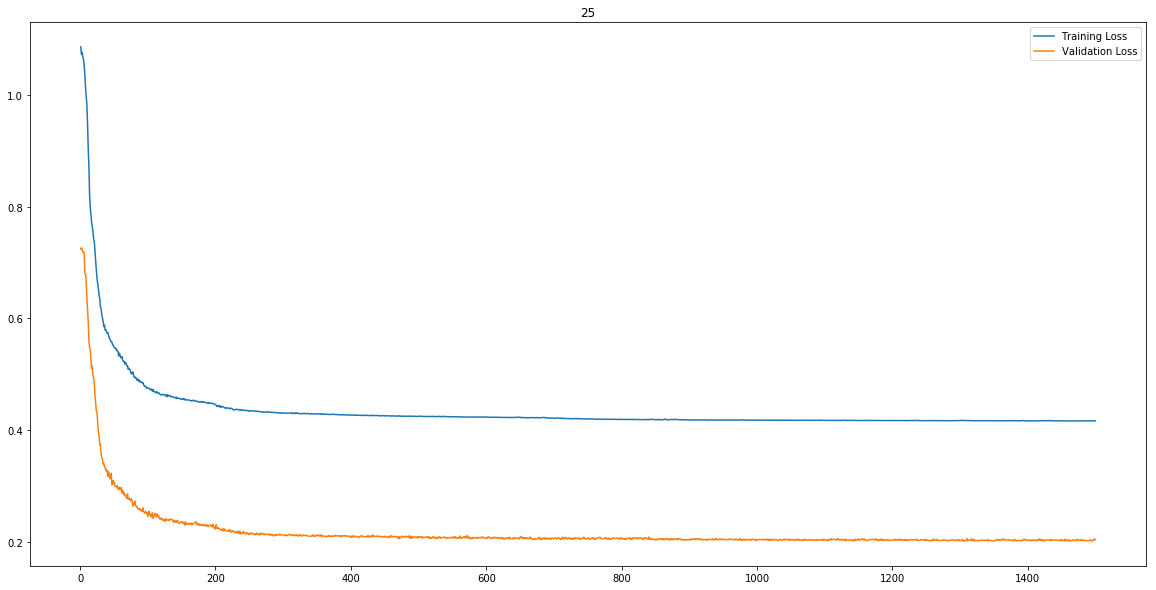

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


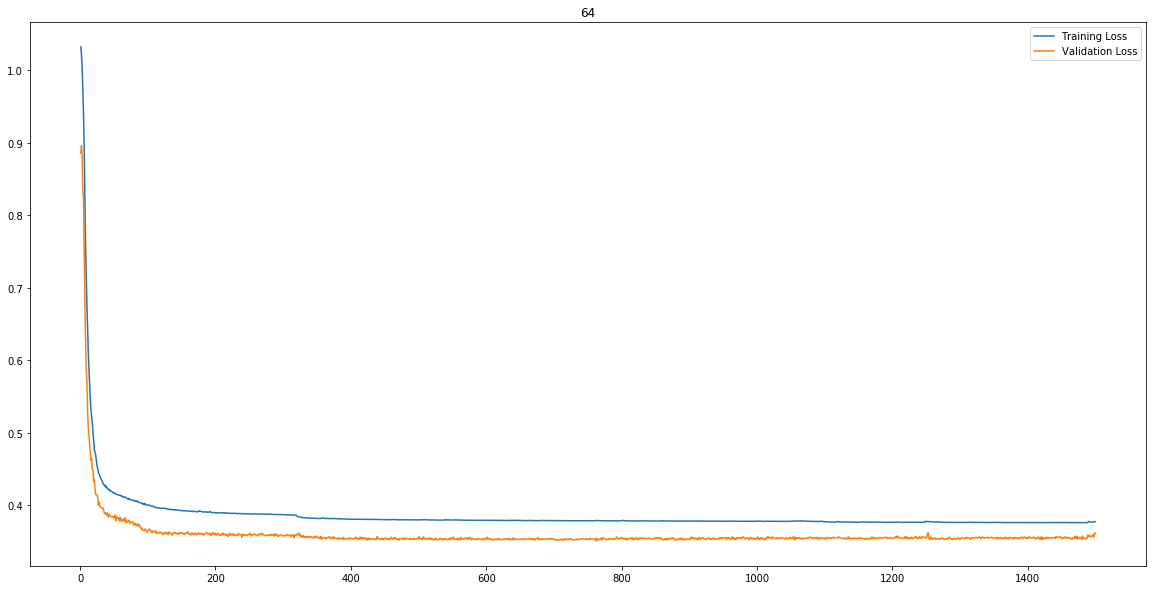

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


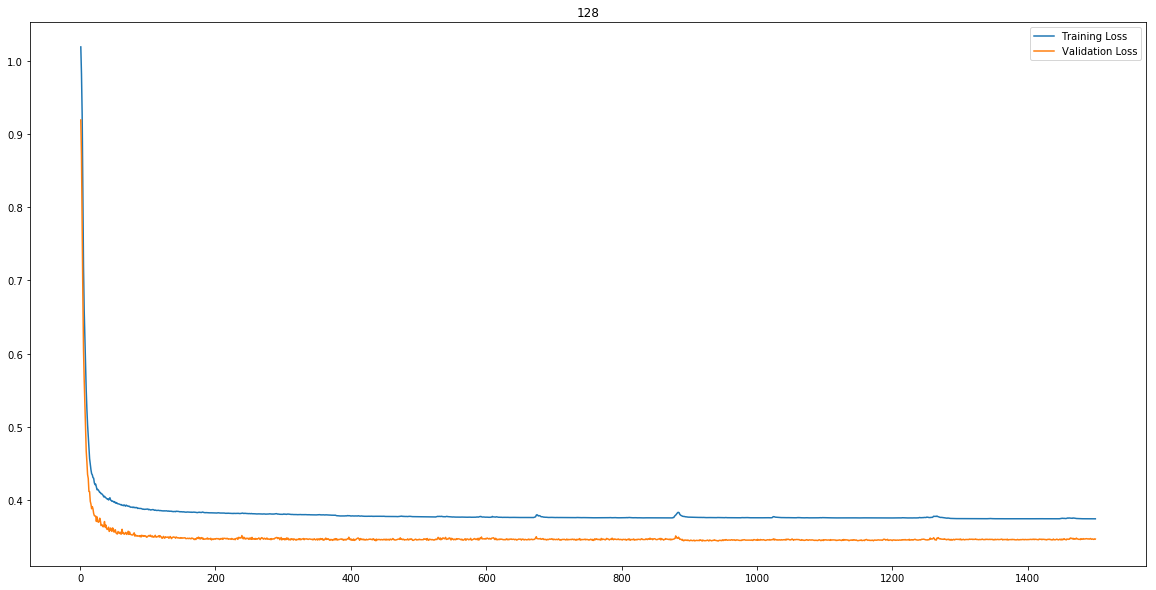

[plotting...]
x: (435, 4, 5), preds: (435, 4, 5)


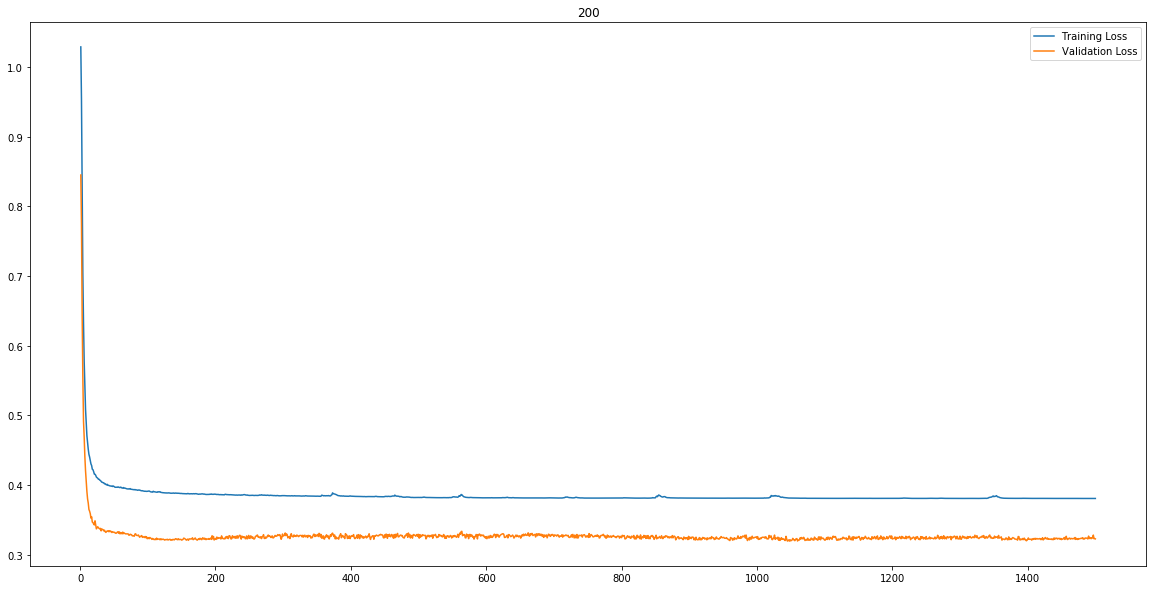

In [12]:
    # Normalization:

    control_data -= mean
    std = control_data.std(axis=0)
    control_data /= std
    pre_data -= mean
    pre_data /= std
    post_data -= mean
    post_data /= std

    #print(std2)
    #print(std)
    #exit()
    # Run the model #

    input_dim = len(_vars)  # vars
    timesteps = NR_VISITS  # visits
    batch_size =   64 # 
    epsilon_std = 1.  #
    latent_dim = 50  #
    epochs = 1500  #
    intermediate_dim = 128  #
    beta = 0 # Param for KL loss
    
    for batch_size in [4,8,16,32,64,128,256]:
        vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
        np.random.shuffle(control_data)
        history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
        preds = vae.predict(control_data, batch_size=batch_size)
        print("[plotting...]")
        print("x: %s, preds: %s" % (control_data.shape, preds.shape))
        plot_loss(batch_size)
    
    batch_size = 32
    
    for latent_dim in [1,5,10,25,50,100,200]:
        vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
        np.random.shuffle(control_data)
        history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
        preds = vae.predict(control_data, batch_size=batch_size)
        print("[plotting...]")
        print("x: %s, preds: %s" % (control_data.shape, preds.shape))
        plot_loss(latent_dim)
        
    latent_dim = 50
    
    for intermediate_dim in [10,25,64,128,200]:
        vae, enc, gen = create_vae(input_dim, timesteps, batch_size, intermediate_dim, latent_dim, epsilon_std, beta)
        np.random.shuffle(control_data)
        history = vae.fit(control_data, control_data, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
        preds = vae.predict(control_data, batch_size=batch_size)
        print("[plotting...]")
        print("x: %s, preds: %s" % (control_data.shape, preds.shape))
        plot_loss(intermediate_dim)
    

# Prediction plots

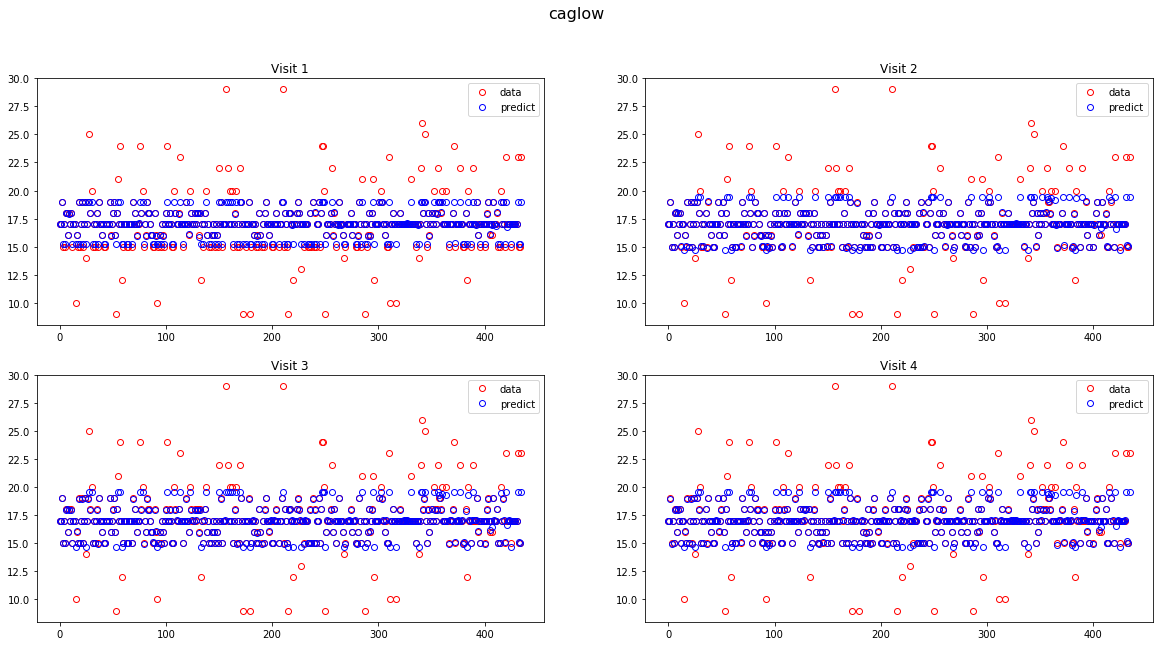

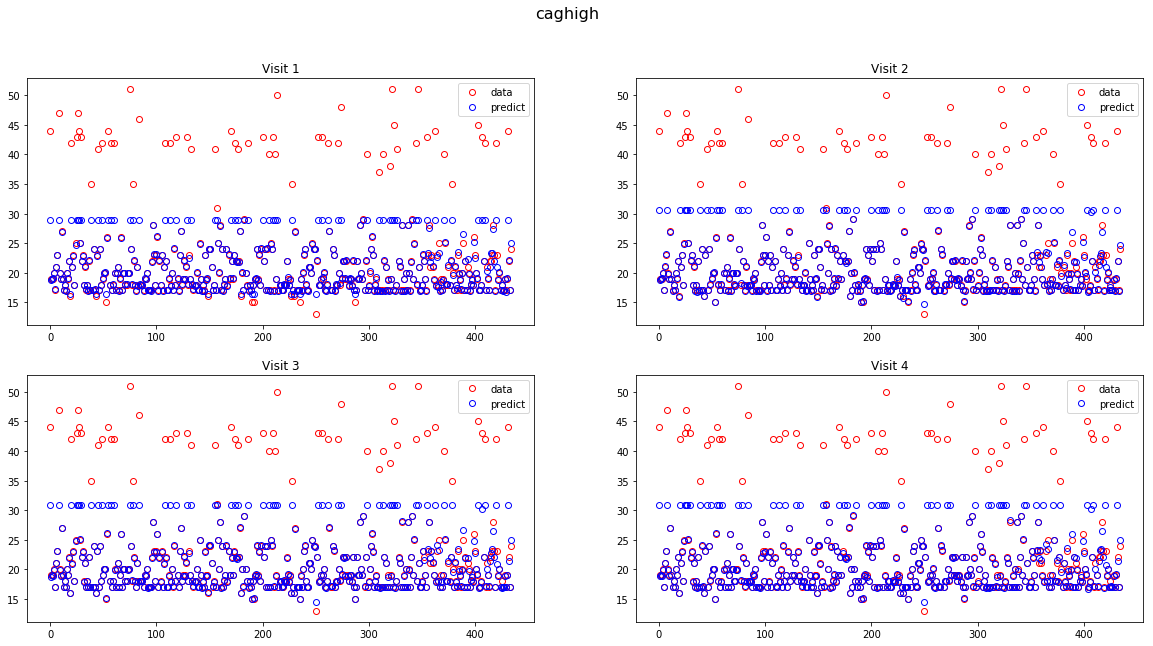

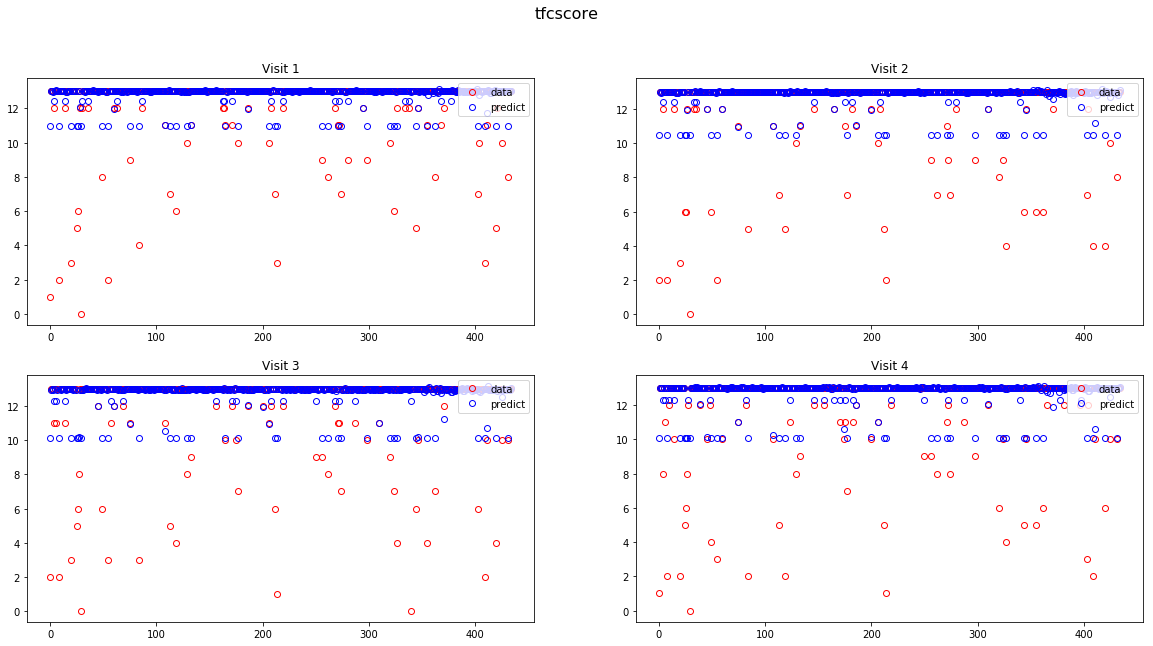

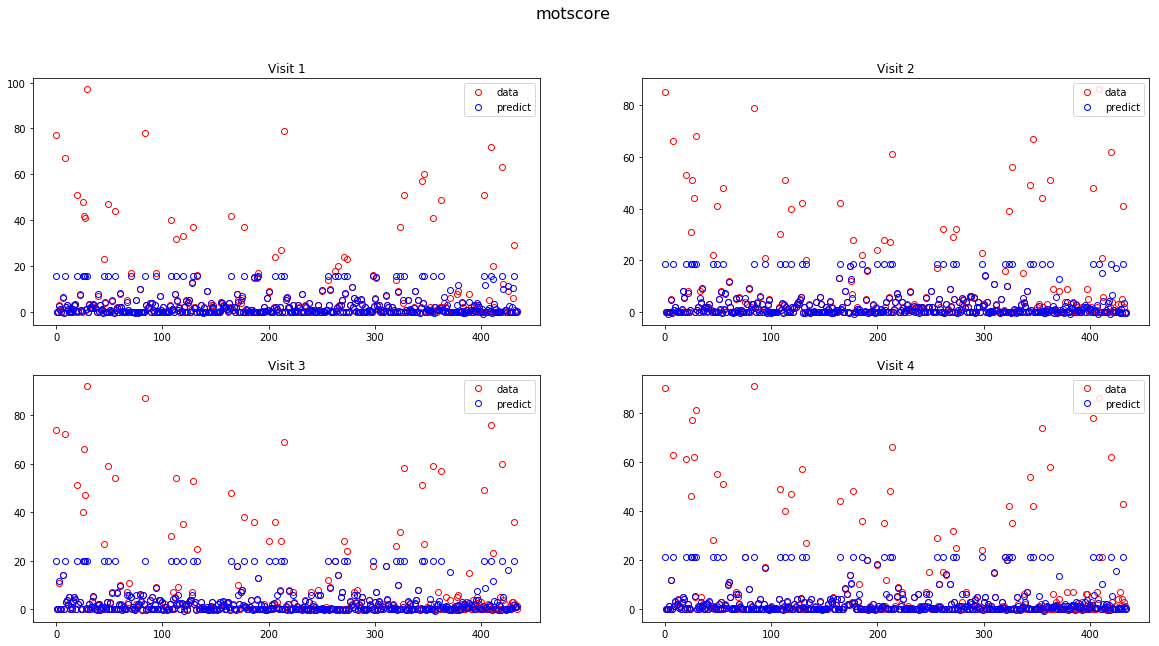

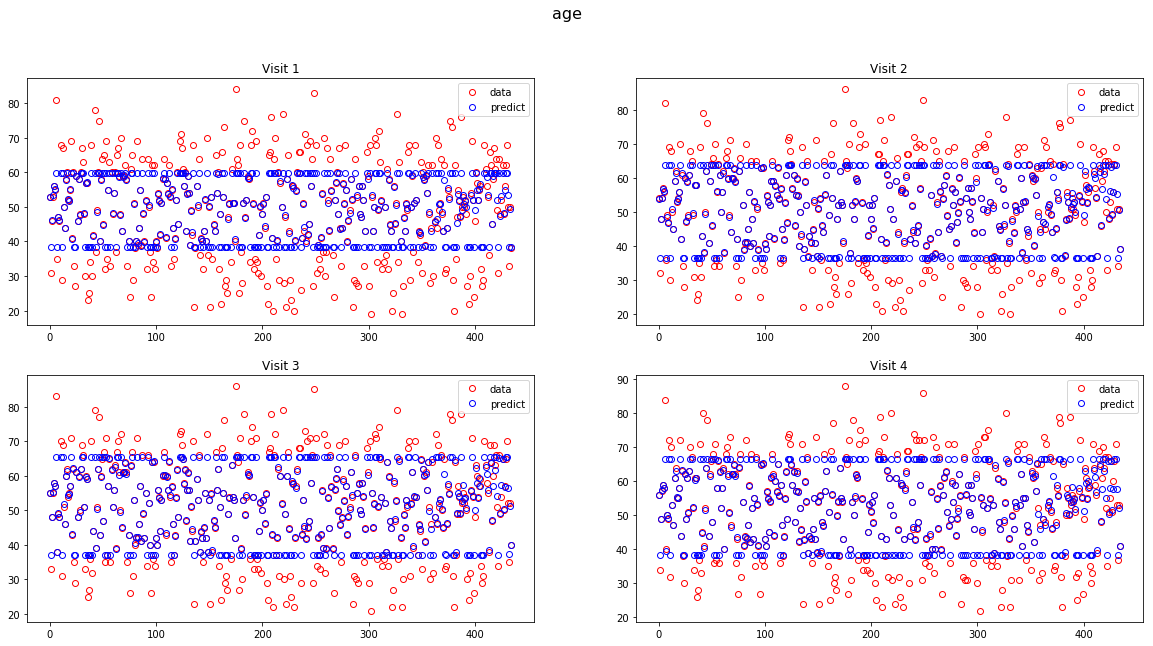

In [13]:
        # Denormalization
        
        control_data *= std
        control_data += mean
        preds *= std
        preds += mean
        
        generate_pred_plots()

In [14]:
#K.tensorflow_backend._get_available_gpus()

In [15]:
#print(range(len(_vars)))
#for i in range(len(_vars)):
#    print(i)